# UrbanSound8K - Analysis 
In this notebook, we look at the time durations and sample rates of the audio files in the UrbanSound8K dataset. These 2 parameters are not uniform across the dataset, thus we will need to choose a strategy to standardize them before we can use them for training a model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa 

In [2]:
# Load dataset metadata
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

Here we add a new column to the metadata file that contains the duration of the audio files in seconds and plot the distribution of the time durations. 

Time duration summary
 count    8732.000000
mean        3.607904
std         0.973570
min         0.054517
25%         4.000000
50%         4.000000
75%         4.000000
max         4.000000


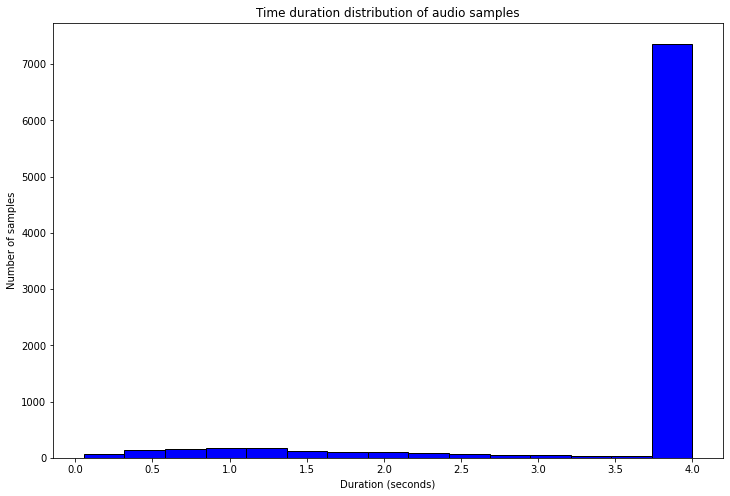

In [25]:
metadata['duration'] = metadata['end'] - metadata['start']
print('Time duration summary\n', metadata['duration'].describe().to_string())

# Plotting the distribution of the duration of the audio files
plt.figure(figsize=(12, 8))
plt.hist(metadata['duration'], bins=15, color='blue', edgecolor='black')
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of samples')
plt.title('Time duration distribution of audio samples')
plt.show()

We see that the vast majority of the audio samples are 4 seconds long. The best strategy would be to pad the audio files that are shorter than 4 seconds with zeros (silence), as this would not introduce any new information into the sampels, and moreover, convolutional neural networks are translation and scale invariant, so the padding should not affect the performance of the model.

In the next block, we add a new column to the metadata file that contains the sample rate of the audio files and plot the distribution of the sample rates.

Sampling rates summary
count      8732.000000
mean      48456.979272
std       15300.080707
min        8000.000000
25%       44100.000000
50%       44100.000000
75%       48000.000000
max      192000.000000

sampling_rate
44100     5370
48000     2502
96000      610
24000       82
16000       45
22050       44
11025       39
192000      17
8000        12
11024        7
32000        4


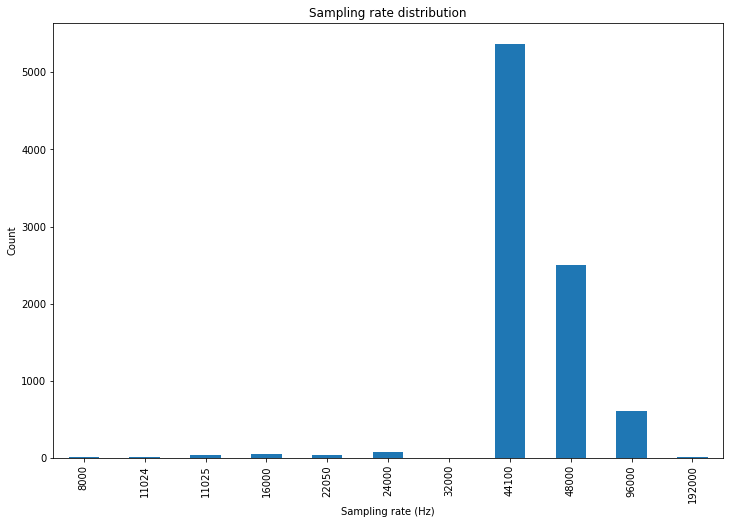

In [26]:
sampling_rates = []

for _, row in metadata.iterrows():
    filename = 'UrbanSound8K/audio/fold' + str(row['fold']) + '/' + row['slice_file_name']
    sr = librosa.get_samplerate(filename)
    sampling_rates.append(sr)

metadata['sampling_rate'] = sampling_rates

print('Sampling rates summary\n' + metadata['sampling_rate'].describe().to_string() + '\n')
print(metadata['sampling_rate'].value_counts().to_string())

# Plotting the distribution of the sampling rates
sampling_rates = metadata['sampling_rate'].value_counts().sort_index()
plt.figure(figsize=(12, 8))
sampling_rates.plot(kind='bar')
plt.title('Sampling rate distribution')
plt.xlabel('Sampling rate (Hz)')
plt.ylabel('Count')
plt.show()

We see that we have 2 dominant sample rates, 44100 Hz (standard CD quality) and 48000 Hz. We will need to resample the audio files to a common sample rate before we can use them for training a model. We will choose 44100 Hz as the common sample rate, as it is the most common sample rate in the dataset. After resampling, we will pad the audio files to 4 seconds as discussed above.